# Data Driven Modeling 3: Regression

In [1]:
#%% Import necessary packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn import linear_model
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_validate, LeaveOneOut, train_test_split
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD


# Set matplotlib parameters for plotting
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['figure.dpi'] = 100.

### 1. Inspect the dataset

(20640, 8)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Text(0, 0.5, 'Latitude')

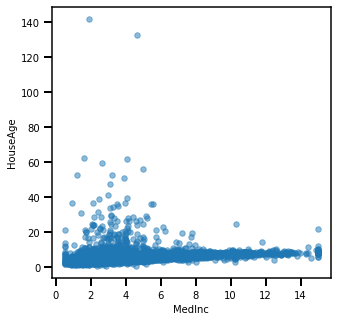

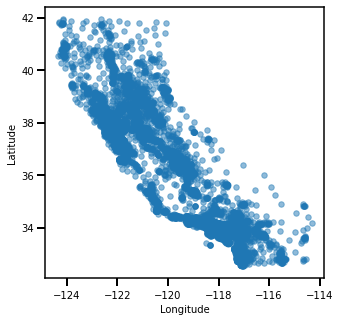

In [2]:
# fetch the housing dataset
dataset = fetch_california_housing()

# extract the features X and reponse y 
X_full, y_full = dataset.data, dataset.target
# check dataset sizes
print(X_full.shape)

# print out the feature names
X_names = dataset.feature_names
print(X_names)
y_name = 'Housing Price'

# Take only 2 features to make visualization easier
# Feature 0 and feature 1 have very different scales and distributions 
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_full[:,0], X_full[:,2], s = 30, alpha = 0.5)
ax.set_xlabel(X_names[0])
ax.set_ylabel(X_names[1])

# plot the last two features which gives the shape of the state of California! 
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_full[:,-1], X_full[:,-2], s = 30, alpha = 0.5)
ax.set_xlabel(X_names[-1])
ax.set_ylabel(X_names[-2])


### 2. Standardize the data to a zero mean and unit variance

The std of each column in original X:
[1.89977569e+00 1.25852527e+01 2.47411320e+00 4.73899376e-01
 1.13243469e+03 1.03857980e+01 2.13590065e+00 2.00348319e+00]
The std of each column in original X:
[1.89977569e+00 1.25852527e+01 2.47411320e+00 4.73899376e-01
 1.13243469e+03 1.03857980e+01 2.13590065e+00 2.00348319e+00]
The std of each column in standardized X:
[1. 1. 1. 1. 1. 1. 1. 1.]
The mean of each column standardized X:
[ 6.60969987e-17  5.50808322e-18  6.60969987e-17 -1.06030602e-16
 -1.10161664e-17  3.44255201e-18 -1.07958431e-15 -8.52651283e-15]


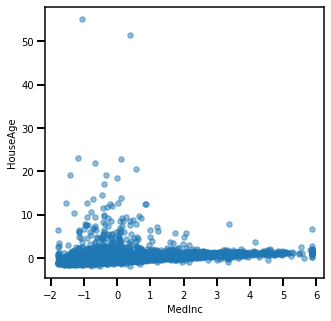

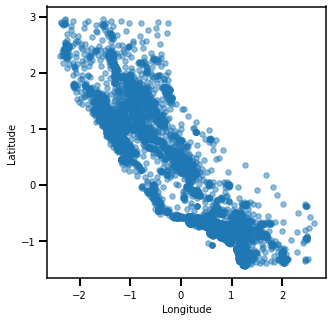

In [3]:
# Preprocess the data 
# Standardize 
scaler = StandardScaler().fit(X_full)
Xs = scaler.transform(X_full)

# Export the mean and std of the original data  
X_std = scaler.scale_ # std for each x variable
print('The std of each column in original X:')
print(X_std)

X_mean = scaler.mean_ # mean for each x variable
print('The std of each column in original X:')
print(X_std)

# Check if there have a unit variance 
Xs_std = np.std(Xs, axis = 0) 
print('The std of each column in standardized X:')
print(Xs_std)

Xs_mean = np.mean(Xs, axis = 0)
print('The mean of each column standardized X:')
print(Xs_mean)


# Feature 0 and feature 1 after standardization
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(Xs[:,0], Xs[:,2], s = 30, alpha = 0.5)
ax.set_xlabel(X_names[0])
ax.set_ylabel(X_names[1])

# Last two features after standardization
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(Xs[:,-1], Xs[:,-2], s = 30, alpha = 0.5)
ax.set_xlabel(X_names[-1])
ax.set_ylabel(X_names[-2])

# Assign Xs to X
X = Xs.copy()
y = y_full.copy()

### 3. Split the data into training and test set, set up cross-validation

In [4]:
# 10 fold cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# check train and test set sizes
print(X_train.shape)
print(X_test.shape)

# Set up cross-validation scheme                                  
kfold = KFold(n_splits = 10, shuffle = True, random_state = 0)
loo = LeaveOneOut()

(16512, 8)
(4128, 8)


### 4. Create helper functions

In [5]:
# Helper function for cross validation
def cross_validation(X, y, model, cv_method): 
    """Cross-validation

    :param X: feature matrix
    :type X: 2D np array
    :param y: response
    :type y: 1D np array
    :param model: regression model
    :type model: sklearn object
    :param cv_method: cross validation method
    :type cv_method: cv object
    :return: mean cv error  
    :rtype: float
    """    

    scores  = cross_validate(model, X, y, cv = cv_method,
                                scoring=('neg_mean_squared_error'),
                                return_train_score=True)
    
    # Use RMSE as the loss function (score)
    # Export train RMSE
    train_RMSE = np.sqrt(np.abs(scores['train_score']))  
    train_RMSE_mean = np.mean(train_RMSE)
    
    # Export cv RMSE (test set in cv is the validation set)
    cv_RMSE = np.sqrt(np.abs(scores['test_score']))  
    cv_RMSE_mean = np.mean(cv_RMSE)

    
    return train_RMSE_mean, cv_RMSE_mean 

### 5. Ordinary Least Squares (OLS)

 MSE of OLS is  0.53
 Test RMSE is  0.73
 Training RMSE is  0.72
 Validation RMSE is  0.73
[ 0.82323627  0.11695782 -0.24405487  0.28112445 -0.00856339 -0.04928231
 -0.90017391 -0.86984436]


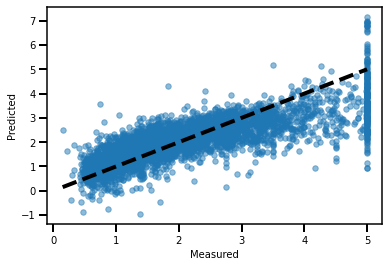

In [6]:
# Create linear regression object including 8 features and linear relation
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)
# Cross validation
train_RMSE, cv_RMSE = cross_validation(X_train, y_train, model = ols, cv_method = kfold)
# Make prediction for the test set and access the error
y_pred = ols.predict(X_test)
test_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
ols_test_mse = mean_squared_error(y_test, y_pred)
print(' MSE of OLS is {0:5.2f}'.format(ols_test_mse))

# Print out performance metrics
print(' Test RMSE is {0:5.2f}'.format(test_RMSE))
print(' Training RMSE is {0:5.2f}'.format(train_RMSE))
print(' Validation RMSE is {0:5.2f}'.format(cv_RMSE))

# Extract parameters from the model
intercept = ols.intercept_
coef = ols.coef_
print (coef)

# Make parity plot
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s = 30, alpha = 0.5)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### 6. Ridge Regression

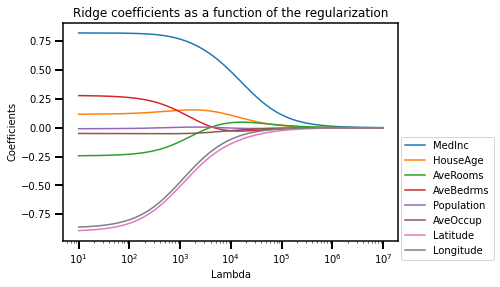

In [7]:
alphas = np.logspace(1, 7, 500)

# Plot ridge coefficients as a function of lambda
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# Display results
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())
ax.legend(labels = X_names, loc = 'upper right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Lambda')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()


In [8]:
# Apply cross-validation to choose the best lambda. cv = none is efficient leave-One-Out cross-validation 
ridgeCV = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgeCV.fit(X_train, y_train)
print('Best lambda is {0:5.2f}'.format(ridgeCV.alpha_))

# Calculate the MSE of the test set
lm_ridge = Ridge(alpha = ridgeCV.alpha_)
lm_ridge.fit(X_train, y_train)
lm_ridge_pred = lm_ridge.predict(X_test)
lm_ridge_mse = mean_squared_error(y_test, lm_ridge_pred)

# Print out performance metrics
print('MSE of Ridge Regression is {0:5.2f}'.format(lm_ridge_mse))
print('Best model coefficients:')
pd.Series(lm_ridge.coef_, index = X_names)


Best lambda is 41.04
MSE of Ridge Regression is  0.53
Best model coefficients:


MedInc        0.822172
HouseAge      0.120212
AveRooms     -0.238247
AveBedrms     0.273408
Population   -0.007376
AveOccup     -0.049686
Latitude     -0.869292
Longitude    -0.838731
dtype: float64

### 7. LASSO Regression

In [9]:
# Create a function called lasso to visualize the effects of lambda
def lasso(alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    df = pd.DataFrame()
    
    df['Feature Name'] = X_names
    
    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)
        
        # Fit the lasso regression
        lasso.fit(X_train, y_train)
        
        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        df[column_name] = lasso.coef_
        
    # Return the datafram    
    return df

# Run the function called, Lasso
lasso([0, .0001, .05, 10])


C:\Users\zongx\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\zongx\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\zongx\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4321.531874042767, tolerance: 2.20991902146108
  positive)


,Feature Name,Alpha = 0.000000,Alpha = 0.000100,Alpha = 0.050000,Alpha = 10.000000
0,MedInc,0.823236,0.822737,0.741593,0.0
1,HouseAge,0.116958,0.117052,0.139614,0.0
2,AveRooms,-0.244055,-0.242723,-0.000000,0.0
3,AveBedrms,0.281124,0.279807,0.000000,-0.0
4,Population,-0.008563,-0.008432,0.000000,-0.0
5,AveOccup,-0.049282,-0.049071,-0.000000,-0.0
6,Latitude,-0.900174,-0.899079,-0.250371,-0.0
7,Longitude,-0.869844,-0.868693,-0.209129,-0.0


Text(0, 0.5, 'Coefficients')

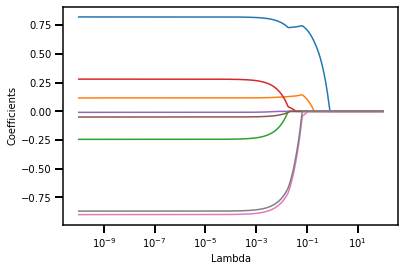

In [10]:
# Calculate the corresponding coefficients
alphas = np.logspace(-10, 2, 500)


lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
# Plot lasso coefficients as a function of lambda
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('Lambda')
plt.ylabel('Coefficients')

Text(0, 0.5, 'Mean Squared Error')

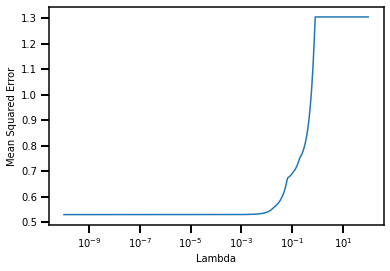

In [11]:
lasso_mses = []

for a in alphas:
    model = Lasso(alpha=a).fit(X_train, y_train)   
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)
    lasso_mses.append(mse)

ax = plt.gca()
ax.plot(alphas, lasso_mses)
ax.set_xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')

In [12]:
# Use cross validation to find the best lambda
alphas = np.logspace(-10, 1, 500)
lasso_cv = LassoCV(alphas = alphas, max_iter=10000)
lasso_cv.fit(X_train, y_train)

# Print out the result
print('Best alpha is {0:5.4f}'.format(lasso_cv.alpha_))

# Build LASSO regression based on the best alpha
lasso = Lasso(alpha = lasso_cv.alpha_, max_iter=10000)
lasso.fit(X_train, y_train)
lasso.set_params(alpha=lasso_cv.alpha_)
lasso_pred = lasso.predict(X_test)

lasso_mse = mean_squared_error(y_test, lasso_pred)

# Print out performance metrics
print('MSE of LASSO Regression is {0:5.2f}'.format(lasso_mse))
print('Best model coefficients:')
pd.Series(lasso.coef_, index=X_names)

Best alpha is 0.0024
MSE of LASSO Regression is  0.53
Best model coefficients:


MedInc        0.811011
HouseAge      0.119219
AveRooms     -0.211512
AveBedrms     0.248995
Population   -0.005384
AveOccup     -0.044144
Latitude     -0.873893
Longitude    -0.842164
dtype: float64

### 8. Elastic Net Regression

Text(0, 0.5, 'Mean Squared Error')

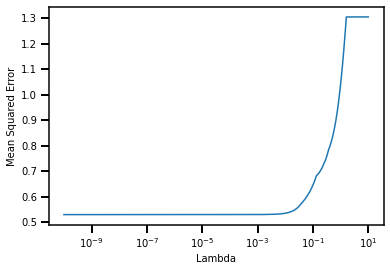

In [13]:
# Calculate the accuracy metrics for a series of alphas
test_mse = []

for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)
    test_mse.append(mse)

ax = plt.gca()
ax.plot(alphas, test_mse)
ax.set_xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')

In [14]:
# Use cross validation to find the best lambda
# By default, l1 ration = 0.5 (ridge regression and lasso contributes equally). Can specify with any number between 0 and 1
elastic_cv = ElasticNetCV(alphas=alphas)
model_ela = elastic_cv.fit(X_train, y_train)

# Print out the result
print('Best alpha is {0:5.4f}'.format(model_ela.alpha_))

# Build Elastic net regression based on the best lambda
ela = ElasticNet(alpha = model_ela.alpha_)
ela.fit(X_train, y_train)
ela.set_params(alpha=model_ela.alpha_)
ela_pred = ela.predict(X_test)

ela_mse = mean_squared_error(y_test, ela_pred)

# Print out performance metrics
print('MSE of Elastic Net Regression is {0:5.2f}'.format(ela_mse))
print('Best model coefficients:')
pd.Series(ela.coef_, index=X_names)


Best alpha is 0.0026
MSE of Elastic Net Regression is  0.53
Best model coefficients:


MedInc        0.816407
HouseAge      0.119820
AveRooms     -0.224281
AveBedrms     0.260550
Population   -0.006283
AveOccup     -0.046795
Latitude     -0.870347
Longitude    -0.839183
dtype: float64

### 9. Principal Component Regression (PCR)

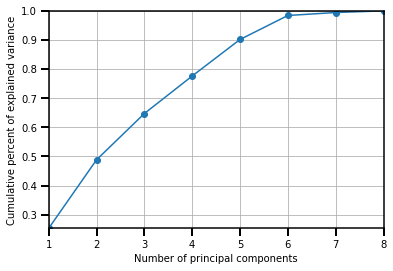

In [15]:
# First perform PCA
def plot_scree(percent_explained_var, n_components=None, **kwargs):

    fig = plt.figure(**kwargs)
    ax = fig.add_subplot(111)

    if not n_components:
        n_components = len(percent_explained_var)

    ax.plot(np.array(range(n_components))+1,
            percent_explained_var[:n_components],
            '-o')
    
    ax.set_xlim(1,n_components)
    ax.set_ylim(percent_explained_var.min(),1)
    
    ax.set_xlabel("Number of principal components")
    ax.set_ylabel("Cumulative percent of explained variance")
    ax.grid()

    return fig, ax

# Apply PCA and calculate explained_variance
pca = PCA()
scores = pca.fit_transform(X)
percent_explained_var = np.cumsum(pca.explained_variance_ratio_)

# Generate scree plot using the helper function
plot_scree(percent_explained_var)
plt.show()


[1.3315653527273859, 1.3106225394732984, 1.307821538220042, 0.7263790089272455, 0.6587592898474595, 0.6567459707671631, 0.5457481202367379, 0.5298849810935669]


Text(0.5, 1.0, 'Housing Price')

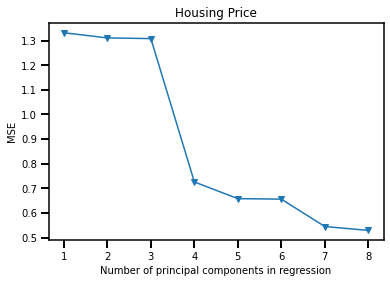

In [16]:
# Linear regression using all principal components
regr = linear_model.LinearRegression()
mse = []

# Perform PCA on the training data and evaluate its test set performance
scores_train = pca.fit_transform(X_train)
regr = linear_model.LinearRegression()
mse = []

# Calculate MSE using CV for the 8 principal components, adding one component at the time
for i in np.arange(1,9):
    score = -1*model_selection.cross_val_score(regr, scores_train[:,:i], y_train.ravel(), cv=kfold, scoring='neg_mean_squared_error').mean()
    mse.append(score)

print(mse)
x_a = [1, 2, 3, 4, 5, 6, 7, 8]
plt.plot(x_a, mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Housing Price')

In [24]:
# Use all principal components and test if the model is the same as OLS
pca = PCA().fit(X_train)
scores_test = pca.transform(X_test)
scores_train = pca.transform(X_train)

# Train regression model on training data
regr = linear_model.LinearRegression()
regr.fit(scores_train, y_train)

# Prediction with the test data
pred = regr.predict(scores_test)
PCR_MSE = mean_squared_error(y_test, pred)
print(' PCR MSE is{0:5.2f}'.format(PCR_MSE))

 PCR MSE is 0.53


 PCR MSE is 0.68


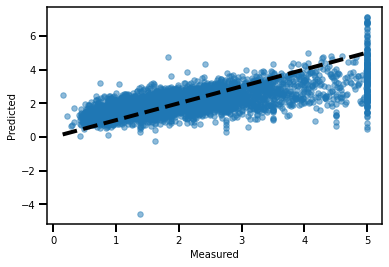

In [25]:
# Choose five principal components and see how it performs on the test data
pca = PCA().fit(X_train)
scores_train = pca.transform(X_train)[:, :6]
scores_test = pca.transform(X_test)[:, :6]

# Train regression model on training data
regr = linear_model.LinearRegression()
regr.fit(scores_train, y_train)

# Prediction with the test data
pred = regr.predict(scores_test)
PCR_MSE = mean_squared_error(y_test, pred)
print(' PCR MSE is{0:5.2f}'.format(PCR_MSE))

# Make parity plot
fig, ax = plt.subplots()
ax.scatter(y_test, pred, s = 30, alpha = 0.5)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### 10. Partial Least Squares (PLS)

 PLS MSE is 0.55


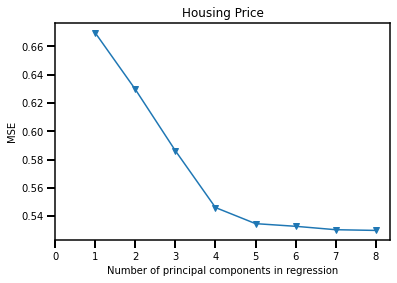

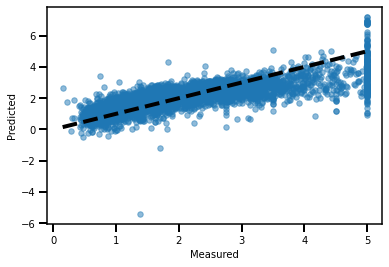

In [19]:
# Directly apply sklearn PLSRegression package
# Calculate cross-validation error
pls_mse = []

for i in np.arange(1, 9):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error').mean()
    pls_mse.append(-score)

# Plot results
plt.plot(np.arange(1, 9), np.array(pls_mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Housing Price')
plt.xlim(xmin=0)

# The elbow occurs when four partial least squares dimensions are used. Now evaluate the corresponding test set MSE
pls = PLSRegression(n_components=4)
pls.fit(X_train, y_train)
PLS_MSE = mean_squared_error(y_test, pls.predict(X_test))
print(' PLS MSE is{0:5.2f}'.format(PLS_MSE))

# Make parity plot
fig, ax = plt.subplots()
ax.scatter(y_test, pls.predict(X_test), s = 30, alpha = 0.5)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Summary

In [20]:
# Summary of all above models
models = {'Models': ['OLS', 'Ridge Regression', 'LASSO', 'Elastic Net', 'PCR', 'PLS'],
          'MSE': [ols_test_mse, lm_ridge_mse, lasso_mse, ela_mse, PCR_MSE, PLS_MSE]}
df = pd.DataFrame(models, columns = ['Models', 'MSE'])
print(df)

             Models       MSE
0               OLS  0.528984
1  Ridge Regression  0.529564
2             LASSO  0.530019
3       Elastic Net  0.529777
4               PCR  0.682886
5               PLS  0.549053
